# Homework w07d04 - DBScan Clustering

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.style.use('ggplot') 
from sklearn import datasets

from math import radians, cos, sin, asin, sqrt

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### 1. Read in the following CSV file containing the outgoing UK postcodes together with their coordinates of longitude and latitude

In [2]:
X = pd.read_csv('https://www.freemaptools.com/download/outcode-postcodes/postcode-outcodes.csv')

#### 2. Load the following function. It calculates the distance between any points on the Earth's surface specified by their longitude and latitude in degrees (for more information, see https://en.wikipedia.org/wiki/Haversine_formula).

In [3]:
def haversine(lonlat1, lonlat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2.)**2 + cos(lat1) * cos(lat2) * sin(dlon/2.)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of the Earth in kilometres.
    return c * r

#### 3. Calculate the distance matrix between each pair of points

In [4]:
my_metric = pdist(X.ix[:,['latitude','longitude']], (lambda u,v: haversine(u,v)))

In [5]:
distance_matrix = squareform(my_metric)

#### 4.a) Do DBScan clustering on the distance matrix with the precomputed metric. Adjust the values of eps and min_samples to obtain a suitable number of clusters.

In [18]:
# use the precomputed metric
db = DBSCAN(eps=32, min_samples=2, metric='precomputed')  
# do your fit on the distance matrix
y_db = db.fit_predict(distance_matrix) 
# Check how many labels
labels=db.labels_
print("Nb unique labels %d" % len(np.unique(labels)))
# Check how many unassigned
print("Nb unassigned data points: %d" % len(labels[labels==-1]))

Nb unique labels 13
Nb unassigned data points: 2


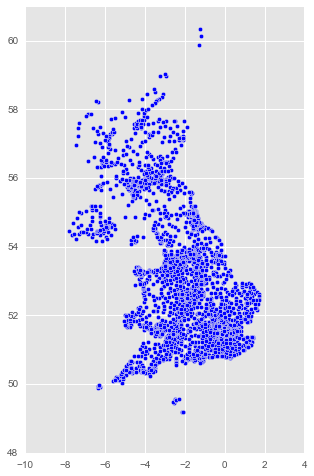

In [7]:
# Plot without cluster
plt.figure(figsize=(5,8))
plt.scatter(X.longitude,X.latitude)
plt.ylim((48,61))
plt.show()

#### 4.b) Produce a scatter plot of the angular variables with points coloured according to their cluster label.

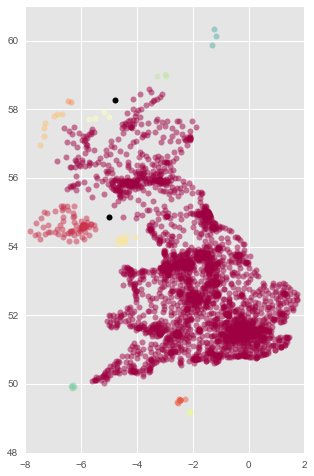

In [19]:
fig = plt.figure(figsize=(5,4))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(5,8))
plt.ylim((48,61))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy.longitude, xy.latitude, 'o', markerfacecolor=col, markeredgecolor='k', markersize=6,alpha=.5)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy.longitude, xy.latitude, 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
plt.show()

#### 5.a) Now use hierarchical clustering using the matrix of latitude and longitude values as an input. 

Hints: 

In the linkage function, use the distance matrix.

For the cophenet coefficient, use the metric defined above.

In [20]:
Z = linkage(distance_matrix,'ward')

In [21]:
cophenet(Z,my_metric)

(0.91120205767390527,
 array([  36.47051609,  548.86233979,  548.86233979, ...,    0.        ,
           0.        ,    0.        ]))

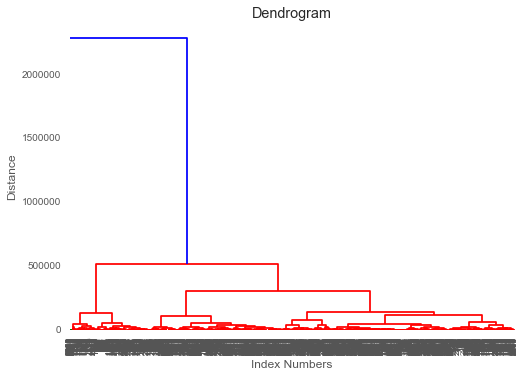

In [22]:
# Plot the dendogram
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

In [34]:
# Assign categories
max_dist = 25000
clusters = fcluster(Z, max_dist, criterion='distance')
n_clust = len(np.unique(clusters))
print("Number of clusters: %d" % n_clust)

Number of clusters: 23


#### 5.b) Tune the threshold to obtain a suitable number of clusters. Produce a scatter plot of latitude and longitude values and colour the points according to their cluster labels.

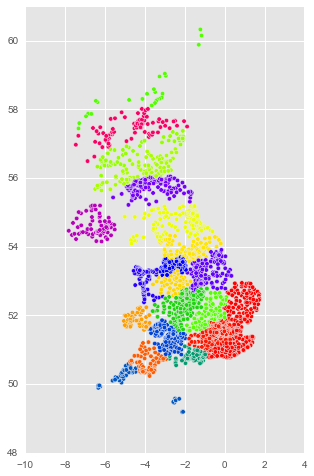

In [27]:
plt.figure(figsize=(5,8))
plt.ylim((48,61))
plt.scatter(X.longitude, X.latitude, c=clusters, cmap='prism')
plt.show()

#### 6.a) Now do a kmeans fit on the distance matrix obtained above. Choose the same number of clusters that you found suitable in the previous parts.

In [35]:
kmeans = cluster.KMeans(n_clusters = n_clust).fit(distance_matrix)

In [36]:
labels = kmeans.predict(distance_matrix)

#### 6.b) Produce a scatter plot of latitude and longitude values and colour the points according to their cluster labels.

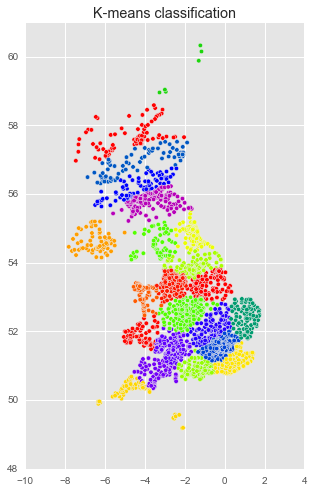

In [41]:
plt.figure(figsize=(5,8))
plt.ylim((48,61))
plt.scatter(X.longitude,X.latitude,c=labels,cmap='prism')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],marker='x',s=200,c='k',linewidths=3)
plt.title("K-means classification")
plt.show()

#### 7. Describe in one sentence the different results obtained with the various clustering algorithms.

DBScan tends to aggregate all contiguous landmass together, hence we have only few clusters.
Hierarchical clustering and KMeans tend to separate various areas in a similar fashion. It would be interesting to choose a number of clusters similar to the number of counties and see if it yields approximately similar results.